In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import pandas_datareader as web
import matplotlib.pyplot as plt

import math
import time
import os

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers.core import Dense, Activation, Dropout

In [5]:
#print(os.getcwd())

/content


In [2]:
data = web.get_data_yahoo("BTC-USD", start = "2015-01-01", end = "2021-06-22")

In [111]:
data.head(5)
data[-5:]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-06-16,39513.671875,37439.675781,38341.421875,38053.503906,3.709667e+10,38053.503906
2021-06-17,38187.261719,35255.855469,38099.476562,35787.246094,3.620089e+10,35787.246094
2021-06-18,36457.796875,34933.062500,35854.527344,35615.871094,3.120728e+10,35615.871094
2021-06-19,36059.484375,33432.074219,35563.140625,35698.296875,3.666403e+10,35698.296875
2021-06-22,31631.478516,31235.783203,31432.669922,31631.478516,5.353971e+10,31631.478516


In [55]:
#data.to_csv("BTC-updated.csv")

In [112]:
input_file="BTC-updated.csv"

In [113]:
# fix random seed for reproducibility
np.random.seed(100)

In [114]:
# load the dataset
df = read_csv(input_file, header=None, index_col=None, delimiter=',')

In [115]:
df.head(5)
df[-5:]

,0,1,2,3,4,5,6
2357,6/17/2021,38187.26172,35255.85547,38099.47656,35787.24609,36200887275,35787.24609
2358,6/18/2021,36457.79688,34933.0625,35854.52734,35615.87109,31207279719,35615.87109
2359,6/19/2021,36059.48438,33432.07422,35563.14063,35698.29688,36664034054,35698.29688
2360,6/21/2021,35687.85938,32721.39453,35687.85938,32930.03125,43962011648,32930.03125
2361,6/22/2021,31631.47852,31235.7832,31432.66992,31631.47852,5.35E+10,31631.47852


In [116]:
# take close price column_index[4]

all_y = df[4].values                        ## values
all_y = all_y[1:]
dataset=all_y.reshape(-1, 1)                ## list

In [117]:
print(len(dataset))
dataset[:5]
dataset[-5:]

2361


array([['35787.24609'],
       ['35615.87109'],
       ['35698.29688'],
       ['32930.03125'],
       ['31631.47852']], dtype=object)

In [118]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [119]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [120]:
# split into train and test sets
train_size = int(len(dataset) * 0.9)                # * 0.5
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [121]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 1                                                   # 240
trainX, trainY = create_dataset(train, look_back)               # Creating Datasets
testX, testY = create_dataset(test, look_back)

In [122]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [123]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

In [124]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 25)                2700      
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 2,726
Trainable params: 2,726
Non-trainable params: 0
_________________________________________________________________


In [125]:
history = model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
34/34 [==============================] - 2s 4ms/step - loss: 0.0678 - accuracy: 1.3156e-04
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0558 - accuracy: 9.9084e-05
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0513 - accuracy: 4.3258e-04
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0469 - accuracy: 1.3156e-04
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0424 - accuracy: 2.6847e-04
Epoch 6/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0334 - accuracy: 8.3690e-05
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0227 - accuracy: 2.9197e-04
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0103 - accuracy: 0.0010
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 1.3156e-04
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0

In [126]:
model.evaluate(trainX, trainY, verbose=1)
model.evaluate(testX, testY, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.0268 - accuracy: 0.0043


[0.026837483048439026, 0.0042553190141916275]

In [127]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [128]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [129]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
trainScore_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print(f"Train Score: {trainScore} RMSE")
print(f"Train Score: {trainScore_mae} MAE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
testScore_mae = mean_absolute_error(testY[0], testPredict[:,0])
print(f"Test Score: {testScore} RMSE")
print(f"Test Score: {testScore_mae} MAE")

Train Score: 293.70878471585485 RMSE
Train Score: 143.84875774903944 MAE
Test Score: 2307.5798791560014 RMSE
Test Score: 1699.4931935159573 MAE


In [130]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [131]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

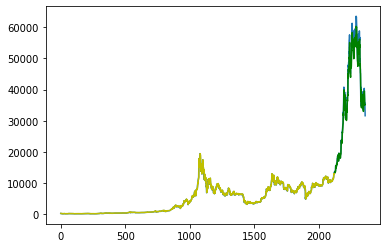

In [132]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot, 'y')

# plot the actual price, prediction in test data=red line, actual price=blue line
plt.plot(testPredictPlot, 'g')

plt.show()

In [135]:
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])
print('testPredictions:')
print(testPredict)

testPrices:
testPredictions:
[[13481.948]
 [13589.907]
 [13822.855]
 [13779.261]
 [13593.847]
 [13991.011]
 [14173.124]
 [15607.259]
 [15593.425]
 [14867.762]
 [15507.916]
 [15362.012]
 [15320.974]
 [15727.595]
 [16296.795]
 [16337.821]
 [16090.753]
 [15979.342]
 [16731.762]
 [17649.84 ]
 [17806.377]
 [17819.291]
 [18612.363]
 [18632.979]
 [18364.662]
 [18358.861]
 [19091.219]
 [18721.547]
 [17161.213]
 [17119.494]
 [17720.918]
 [18174.832]
 [19601.332]
 [18791.37 ]
 [19183.389]
 [19423.826]
 [18689.668]
 [19137.258]
 [19325.146]
 [19174.076]
 [18316.492]
 [18545.945]
 [18261.123]
 [18057.875]
 [18792.02 ]
 [19125.596]
 [19228.227]
 [19395.957]
 [21255.777]
 [22718.816]
 [23043.98 ]
 [23758.252]
 [23375.295]
 [22716.783]
 [23673.596]
 [23144.943]
 [23627.674]
 [24532.822]
 [26254.656]
 [26094.898]
 [26882.254]
 [27150.945]
 [28578.834]
 [28733.78 ]
 [29092.498]
 [31733.664]
 [32358.975]
 [31585.13 ]
 [33512.01 ]
 [36194.38 ]
 [38587.465]
 [39919.79 ]
 [39413.312]
 [37636.27 ]
 [35005.8

In [136]:
print(len(testPrices))
print(len(testPredict))

2123
235


In [62]:
# export prediction and actual prices
#df = pd.DataFrame(data={"prediction": np.around(list(testPredict.reshape(-1)), decimals=2), "test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
df1 = pd.DataFrame(data={"prediction": np.around(list(testPredict.reshape(-1)), decimals=2)})
df2 = pd.DataFrame(data={"test_price": np.around(list(testPrices.reshape(-1)), decimals=2)})
df1.to_csv("lstm_result_new_BTC_1.csv", sep=';', index=None)
df2.to_csv("lstm_result_new_BTC_2.csv", sep=';', index=None)